## Load Data
The training data will be loaded into the variables X and y. There are 5000 training examples. Each training example is a 20 pixel by 20 pixel grayscale image of a digit from 0 to 9. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. So X is a 5000 by 400 matrix. For y, “0” digit is labeled as “10”, while the digits “1” to “9” are labeled as “1” to “9”.

In [15]:
from scipy.io import loadmat

data = loadmat('./ex4/ex4data1.mat')
X = data['X']
y = data['y']

In [32]:
X.shape

(5000, 400)

In [33]:
y.shape

(5000, 1)

## Visualize Data
Out of the 5000 training examples (images), we display 100 randomly selected images here. 

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def displayData(X,y):
    fig,ax = plt.subplots(10,10,figsize=(8, 8))
    for i in range(10):
        for j in range (10):
            ax[i,j].axis('off')
            ax[i,j].imshow(X[np.random.randint(5000)].reshape((20,20),order='F'))

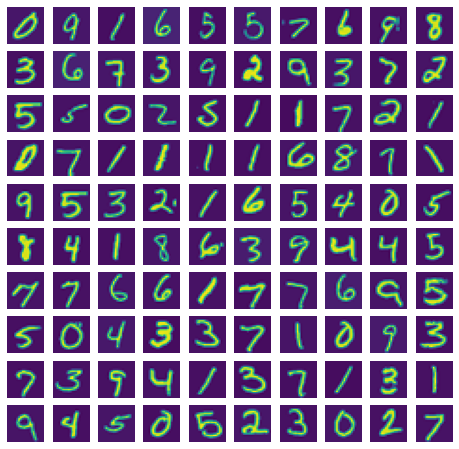

In [17]:
displayData(X,y)

## Neural Network Model
The Neural Network has 3 layers – an input layer, a hidden layer and an output layer. Since the images are of size 20 × 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1). We are provided with a set of pre-trained network parameters (Theta1, Theta2). The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [18]:
data = loadmat('./ex4/ex4weights.mat')
theta1 = data['Theta1']
theta2 = data['Theta2']

input_units  = 400
hidden_units = 25
output_units = 10

## Feedforward and Cost function
In this section we implement the Cost function and the FeedForward function (to calculate gradient for the neural network). The cost function is regularized.

The original labels (in the variable y) were 1, 2, ..., 10 but for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1 (One-Hot Encoding).

In [19]:
import pandas as pd

def sigmoid(x):
    return 1/(1+np.exp(-x))

def feedForward(params, input_units, hidden_units, output_units, X):
    theta1 = np.reshape(params[:hidden_units*(input_units+1)], (hidden_units, input_units+1))
    theta2 = np.reshape(params[hidden_units*(input_units+1):], (output_units, hidden_units+1))
    a = X.shape[0]
    out_iLayer = np.hstack((np.ones((a,1)), X))
    
    in_hLayer = np.matmul(out_iLayer, theta1.T)
    out_hLayer = sigmoid(in_hLayer)
    out_hLayer = np.hstack((np.ones((a,1)), out_hLayer))
    
    in_oLayer = np.matmul(out_hLayer, theta2.T)
    out_oLayer = sigmoid(in_oLayer)
    
    return out_oLayer, in_oLayer, out_hLayer, in_hLayer, out_iLayer

def nnCostFunction(params, input_units, hidden_units, output_units, X, y, lambda_):
    hx,_,_,_,_ = feedForward(params, input_units, hidden_units, output_units, X)
    theta1 = np.reshape(params[:hidden_units*(input_units+1)], (hidden_units, input_units+1))
    theta2 = np.reshape(params[hidden_units*(input_units+1):], (output_units, hidden_units+1))
    n = y.shape[0]
    y = pd.get_dummies(y.flatten())   
    J = -1/n * np.sum(np.sum(np.multiply(y,np.log(hx)) + np.multiply((1-y),np.log(1-hx)))) + (lambda_/(2*n)) * (np.sum(theta1[:,1:]**2) + np.sum(theta2[:,1:]**2))
    return J

In [20]:
lambda_ = 1
params = np.hstack((theta1.flatten(), theta2.flatten()))
cost = nnCostFunction(params, input_units, hidden_units, output_units, X, y, lambda_)
print("Initial Cost=",cost)

Initial Cost= 0.38376985909092354


## Backpropagation
Here we implement the backpropagation algorithm to compute the gradient for the regularized neural network. The gradient function used here is Sigmoid gradient function

In [21]:
def sigmoidGradient(z):
    return np.multiply(sigmoid(z), 1-sigmoid(z))

In [22]:
def randInitializeWeights(L_out, L_in):
    epsilon_init = 0.12
    return np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init

In [23]:
theta1_init = randInitializeWeights(hidden_units, input_units)
theta2_init = randInitializeWeights(output_units, hidden_units)

In [24]:
def backpropagation(params, input_units, hidden_units, output_units, X, y, lambda_):
    theta1 = np.reshape(params[:hidden_units*(input_units+1)], (hidden_units, input_units+1))
    theta2 = np.reshape(params[hidden_units*(input_units+1):], (output_units, hidden_units+1))
    y = pd.get_dummies(y.flatten()).to_numpy(dtype='float32')
    m = y.shape[0] 
    out_oLayer, in_oLayer, out_hLayer, in_hLayer, out_iLayer = feedForward(params, input_units, hidden_units, output_units, X)

    delta1 = np.zeros(theta1.shape)  
    delta2 = np.zeros(theta2.shape)  
    
    for t in range(m):
        a1 = out_iLayer[t,:]  
        
        z2 = in_hLayer[t,:]  
        a2 = out_hLayer[t,:]  
        
        z3 = in_oLayer[t,:]
        a3 = out_oLayer[t,:]
        
        yt = y[t,:] 
        
        d3 = (a3 - yt)[:,np.newaxis].T 
        d2 = np.matmul(theta2.T, d3.T) * sigmoidGradient(np.hstack((np.ones(1), z2))[:,np.newaxis]) 

        delta1 = delta1 + d2[1:] * a1.T
        delta2 = delta2 + d3.T * a2.T
        
    delta1 = delta1 / m
    delta2 = delta2 / m
    
    # Adding the gradient regularization term
    delta1[:,1:] = delta1[:,1:] + (theta1[:,1:] * lambda_) / m
    delta2[:,1:] = delta2[:,1:] + (theta2[:,1:] * lambda_) / m
    
    return np.hstack((delta1.flatten(), delta2.flatten()))

In [25]:
params_init = np.hstack((theta1_init.flatten(), theta2_init.flatten()))
backpropagation_params = backpropagation(params_init, input_units, hidden_units, output_units, X, y, lambda_)

## Optimization and Prediction
Here we find the optimized parameters for the neural network using the "fmin_cg" function. The optimal parameters are then used to predict the results on our original dataset and chcked for accuarcy

In [28]:
from scipy.optimize import fmin_cg

opt_params = fmin_cg(f=nnCostFunction, x0=params_init, fprime=backpropagation, args=(input_units, hidden_units, output_units, X, y, lambda_), maxiter=200)
theta1_opt = np.reshape(opt_params[:hidden_units*(input_units+1)], (hidden_units, input_units+1))
theta2_opt = np.reshape(opt_params[hidden_units*(input_units+1):], (output_units, hidden_units+1))

         Current function value: 0.335453
         Iterations: 200
         Function evaluations: 432
         Gradient evaluations: 432


In [27]:
def prediction(theta1, theta2, X):
    a = X.shape[0]
    X = np.hstack((np.ones((a,1)), X))
    out_ih = sigmoid(np.matmul(X, theta1.T))
    out_ih = np.hstack((np.ones((a,1)), out_ih))
    out_ho = sigmoid(np.matmul(out_ih, theta2.T))
    return np.argmax(out_ho, axis = 1)+1

predY = prediction(theta1_opt, theta2_opt, X)
print("Accuracy=",np.mean(predY == y.flatten()) * 100)

Accuracy= 99.44
